In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig(filename)

In [3]:
full_df = pd.read_csv('data/parsed_chase.csv')
df, test_df = train_test_split(full_df, test_size=0.2, random_state=1000, stratify=full_df["Chaser"])
print("Training Episodes: {}, Test Episodes: {}".format(len(df), len(test_df)))
df.head()

Training Episodes: 1163, Test Episodes: 291


,Series,Episode,AirDate,Chaser,P1,P2,P3,P4,NPlayers,PTotal,playerScore,chaserScore,playerWin,remainingTime
918,10,2,2016-04-18,Shaun Wallace,7000.0,4000.0,3000.0,7000.0,4.0,21000.0,19,19,False,4.0
253,8,109,2015-03-20,Anne Hegerty,6000,-,-,5,2.0,6005.0,9,9,False,43.0
1357,13,84,2020-03-09,Shaun Wallace,4000.0,5000.0,5000.0,4000.0,4.0,18000.0,12,12,False,56.0
1092,10,176,2017-04-24,Anne Hegerty,7000.0,4000.0,5000.0,4000.0,4.0,20000.0,13,13,False,11.0
493,3,19,2011-01-27,Shaun Wallace,7000.0,-,8000.0,9000.0,3.0,24000.0,27,15,True,0.0


In [4]:
def catgeroise_earnings(input_earning):
    if input_earning == "-":
        return "DNF"
    try:
        earning_value = float(input_earning)
    except:
        return "NA"
    
    if earning_value >= 14000:
        return "High"
    elif earning_value <= 2000:
        return "Low"

    return "Medium"

In [5]:
def get_dataframes(keep_columns = None):
    """ 
    1) Load the dataframe CSV,
    2) Only keep columns according to the keep_columns variable
    2) If Chasers column is kept, One hot encode the Chasers 
    3) train/test split the data, always stratifies on the chaser column
    4) return dataframes
    """
    
    df = pd.read_csv('data/parsed_chase.csv')
    df["Chaser"] = df["Chaser"].str.replace(' ', '')
    
    # Categroisation of player earnings
    players = ["P1", "P2", "P3", "P4"]
    player_earnings = ["DNF", "Low", "Medium", "High"]
    for p in players:
        df[p] = df.apply(lambda row: catgeroise_earnings(row[p]), axis=1) 
    for p in player_earnings:
        df["PCount_" + p] = (df["P1"] == p).astype(int) + (df["P2"] == p).astype(int) + (df["P3"] == p).astype(int) + (df["P4"] == p).astype(int)

    X = df.copy()
    #X = X.drop(['playerWin', 'Series', 'Episode', 'AirDate', 'chaserScore', 'remainingTime'], axis=1)    
    X = X.drop(['playerWin', 'AirDate', 'chaserScore', 'remainingTime'], axis=1)    
    
    if keep_columns != None:
        X = X[keep_columns]
            
    if keep_columns != None and "Chaser" in keep_columns:
        df_chasers = pd.get_dummies(df["Chaser"], prefix='chaser_')
        X = pd.concat([X, df_chasers],axis=1)        

    if "Chaser" in X:
        X = X.drop('Chaser', axis=1)    
        
    y = df[["playerWin"]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1994, stratify=df[["Chaser"]])
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = get_dataframes(["Chaser", "PTotal", "P1", "P2", "P3", "P4", 'Episode', 'Series', "playerScore", "NPlayers"])

In [7]:
X_train, X_test, y_train, y_test = get_dataframes(["Chaser"])

In [8]:
X_train, X_test, y_train, y_test = get_dataframes(["playerScore"])

In [9]:
X_train, X_test, y_train, y_test = get_dataframes(["Chaser", "PTotal", "P1", "P2", "P3", "P4", 'Series', "playerScore", "NPlayers"])

In [10]:
X_train, X_test, y_train, y_test = get_dataframes(["Chaser", "PTotal", "playerScore", "PCount_Low", "PCount_Medium", "PCount_High"])

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#rfc = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight={False:1,True:10}) 
rfc = RandomForestClassifier(n_jobs=-1, random_state=42) 

param_grid = { 
    'n_estimators': [10, 50, 100, 200],
    'max_features': ["auto", "sqrt", "log2"],
    'bootstrap': [True],
    'max_depth' : [2, 4, 8, 16, 32],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring='roc_auc')
CV_rfc.fit(X_train, y_train.values.ravel())

print(CV_rfc.best_params_)

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}


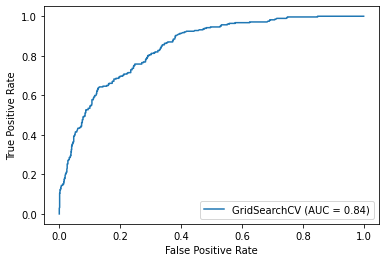

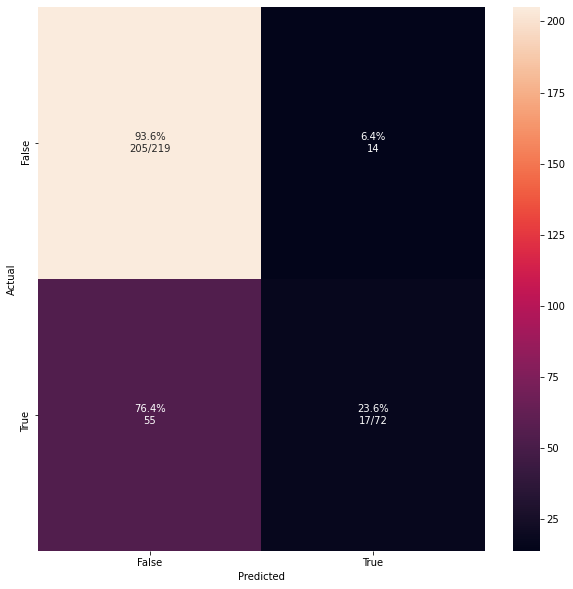

In [12]:
from sklearn import metrics
metrics.plot_roc_curve(CV_rfc, X_train, y_train)
plt.show()
from sklearn.metrics import accuracy_score

y_pred = CV_rfc.predict(X_test)
accuracy_score(y_test, y_pred)

cm_analysis(y_test, y_pred, "test_plot.pdf", CV_rfc.classes_, ymap=None, figsize=(10,10))